# Ir Além 2 — ML Pipeline
This notebook trains a simple classifier using data collected by `collector.py` into `sensor_data.csv`. It also exports the model as `classifier.pkl` for real-time inference.

## 1. Setup & Imports
Installs dependencies (if needed) and imports libraries.

In [1]:
# If running in a fresh environment, uncomment: 
# %pip install -q pandas scikit-learn joblib matplotlib seaborn
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # optional alternative
import joblib

# Locate CSV in either notebook folder or repo root
candidates = [Path('sensor_data.csv'), Path('..') / 'sensor_data.csv']
data_path = next((p for p in candidates if p.exists()), None)
assert data_path is not None, 'sensor_data.csv not found. Run collector.py first.'
print(f'Using dataset: {data_path.resolve()}')

Using dataset: /home/yan/Documents/Git/SmartCrops-IoT-ML-System/sensor_data.csv


## 2. Load & Explore
Load the collected dataset and quickly inspect distributions.

In [2]:
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(66, 4)


,temperature,humidity,moisture,label
0,25.0,60.0,100.0,Healthy
1,25.0,60.0,0.0,Unhealthy
2,25.0,60.0,100.0,Healthy
3,25.0,60.0,0.0,Unhealthy
4,25.0,60.0,0.0,Unhealthy


In [3]:
display(df.describe(include='all'))
print('Class balance:')
print(df['label'].value_counts())

,temperature,humidity,moisture,label
count,66.0,66.0,66.000000,66
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,Unhealthy
freq,NaN,NaN,NaN,50
mean,25.0,60.0,28.939394,NaN
std,0.0,0.0,40.828300,NaN
min,25.0,60.0,0.000000,NaN
25%,25.0,60.0,0.000000,NaN
50%,25.0,60.0,1.000000,NaN
75%,25.0,60.0,52.000000,NaN


Class balance:
label
Unhealthy    50
Healthy      16
Name: count, dtype: int64


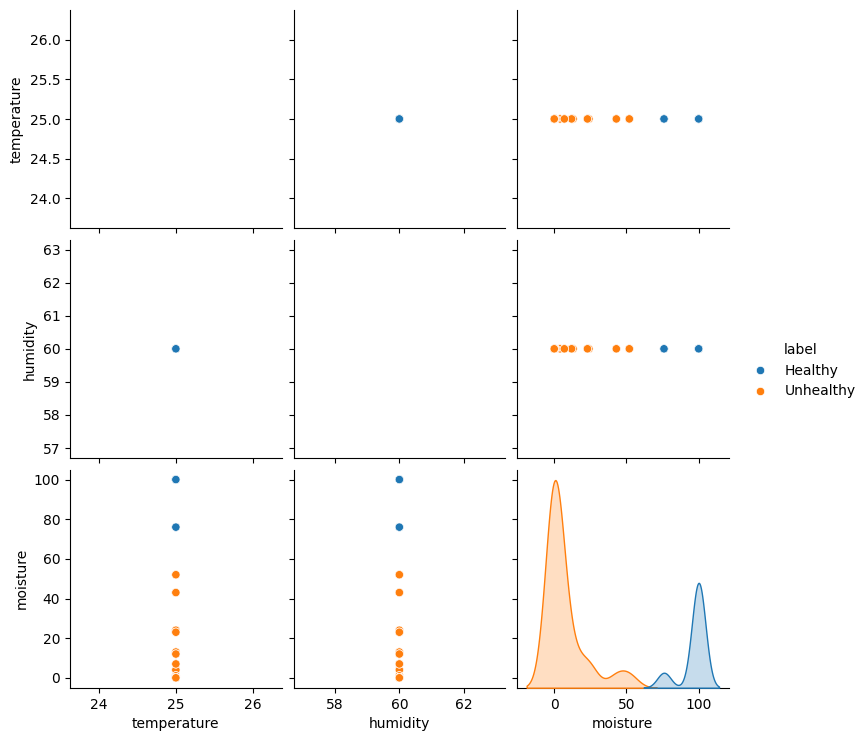

In [4]:
sns.pairplot(df[['temperature','humidity','moisture','label']], hue='label')
plt.show()

## 3. Train/Test Split & Baseline Model
Train a simple pipeline and evaluate performance.

## 2.1 Optional: Synthesize extra points (class balancing)
If the dataset is small or imbalanced, this augments with light noise around existing samples.

              precision    recall  f1-score   support

   Unhealthy       1.00      1.00      1.00        30
     Healthy       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



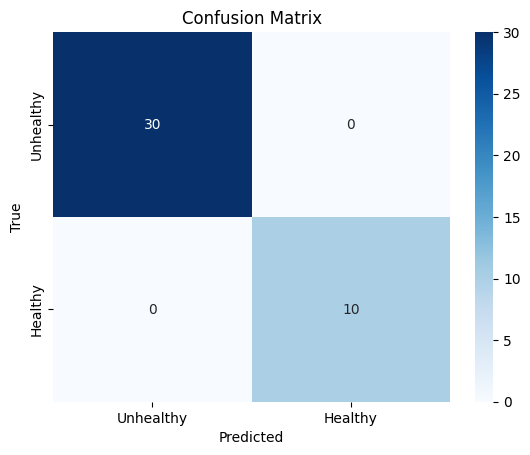

In [6]:
X = df[['temperature', 'humidity', 'moisture']].values.astype(float)
y = (df['label'] == 'Healthy').astype(int).values  # Healthy=1, Unhealthy=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Baseline: Logistic Regression (fast and lightweight)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
print(classification_report(y_test, pred, target_names=['Unhealthy', 'Healthy']))
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unhealthy','Healthy'], yticklabels=['Unhealthy','Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 4. Cross-Validation (optional)
Quick 5-fold cross-validation score to sanity check.

In [7]:
scores = cross_val_score(pipeline, X, y, cv=5)
print('LogReg CV Accuracy: %.3f ± %.3f' % (scores.mean(), scores.std()))

LogReg CV Accuracy: 0.995 ± 0.010


## 5. Save Model
Export the trained pipeline to `classifier.pkl` for `collector.py`.

In [8]:
joblib.dump(pipeline, 'classifier.pkl')
Path('classifier.pkl').exists()

True

In [5]:
# Augment optionally — set AUGMENT=True to enable
AUGMENT = True
MULTIPLIER = 2  # how many synthetic samples per real sample
if AUGMENT:
    rng = np.random.default_rng(42)
    feats = df[['temperature','humidity','moisture']].values.astype(float)
    labels = (df['label'] == 'Healthy').astype(int).values
    std = feats.std(axis=0, ddof=1)
    noise_scale = np.maximum(std * 0.05, 0.2)  # small noise; ensure non-zero
    synth_X = []
    synth_y = []
    for i in range(len(feats)):
        for _ in range(MULTIPLIER):
            noise = rng.normal(0.0, noise_scale)
            x_new = feats[i] + noise
            x_new[2] = np.clip(x_new[2], 0, 100)  # moisture in [0,100]
            synth_X.append(x_new)
            synth_y.append(labels[i])
    synth_df = pd.DataFrame(synth_X, columns=['temperature','humidity','moisture'])
    synth_df['label'] = np.where(np.array(synth_y)==1, 'Healthy', 'Unhealthy')
    df = pd.concat([df, synth_df], ignore_index=True)
    print('After augmentation:', df.shape)


After augmentation: (198, 4)
